## Generate Ratings

In [4]:
%load_ext autoreload
%autoreload 2

import json
import os, sys
ROOT = os.path.abspath("..")
sys.path.insert(0, ROOT)

from rich import print
from tqdm import tqdm

from src.utils.trad_metrics import TradMetrics
from lang_datasets.scripts.constants import LANGUAGES

In [12]:
trad_metrics = TradMetrics()

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../../../../../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`
Encoder model frozen.
/Users/yixiantan/opt/miniconda3/envs/omscs-llm/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [13]:
RATINGS_FILE = "../ratings/flores200-ratings.json"
TRANSLATIONS_FILE = "../lang_datasets/flores200_dataset/flores_sample_translations.json"

CANDIDATE_MAP = {
    "candidate_1": "google_translate",
    "candidate_2": "nllb_translate",
    "candidate_3": "llm_translate",
}

with open(RATINGS_FILE, "r", encoding="utf-8") as f:
    ratings = json.load(f)

with open(TRANSLATIONS_FILE, "r", encoding="utf-8") as f:
    translations = json.load(f)

In [ ]:
# Per language model rating
def get_candidate_ratings(candidate_id, languages):

    candidate_ratings = {
        candidate_id: {
            language: {
                "sentence_bleu": {"scores": [], "avg": None},
                "chrf": {"scores": [], "avg": None},
                "comet": {"scores": [], "avg": None},
            }
            for language in languages
        }
    }

    for data in tqdm(ratings):
        curr_lang = data["language_code"]
        source_sentence = data["source_sentence"]
        reference_sentence = data["original_english_text"]
        for candidate in data["candidate_sentence_evaluations"]:
            if candidate["candidate_id"] != candidate_id:
                continue

            candidate_sentence = candidate["candidate_sentence"]
            review_all_scores = trad_metrics.review_all_models(
                [candidate_sentence], reference_sentence, source_sentence
            )

        # Append the scores to the candidate ratings
        candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["scores"].append(
            review_all_scores["sentence_bleu"][0]
        )
        candidate_ratings[candidate_id][curr_lang]["chrf"]["scores"].append(
            review_all_scores["chrf"][0]
        )
        candidate_ratings[candidate_id][curr_lang]["comet"]["scores"].append(
            review_all_scores["comet"][0]
        )

        # Update the average scores
        candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["avg"] = (
            sum(candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["scores"]) /
            len(candidate_ratings[candidate_id][curr_lang]["sentence_bleu"]["scores"])
        )
        candidate_ratings[candidate_id][curr_lang]["chrf"]["avg"] = (
            sum(candidate_ratings[candidate_id][curr_lang]["chrf"]["scores"]) /
            len(candidate_ratings[candidate_id][curr_lang]["chrf"]["scores"])
        )
        candidate_ratings[candidate_id][curr_lang]["comet"]["avg"] = (
            sum(candidate_ratings[candidate_id][curr_lang]["comet"]["scores"]) /
            len(candidate_ratings[candidate_id][curr_lang]["comet"]["scores"])
        )

    return candidate_ratings

100%|██████████| 90/90 [01:03<00:00,  1.43it/s]


In [17]:
# Best candidate from ALT-Bench ratings

alt_bench_ratings = {
    language: {
        "best_candidate": None,
        "sentence_bleu": {"scores": [], "avg": None},
        "chrf": {"scores": [], "avg": None},
        "comet": {"scores": [], "avg": None},
    }
    for language in LANGUAGES.keys()
}

for data in ratings:
    curr_lang = data["language_code"]
    source_sentence = data["source_sentence"]
    reference_sentence = data["original_english_text"]
    best_candidate_id_and_sentence = data["best_candidate_id_and_sentence"]
    best_candidate_id = best_candidate_id_and_sentence[0:11]
    best_candidate_sentence = best_candidate_id_and_sentence[13:]

    review_all_scores = trad_metrics.review_all_models(
        [best_candidate_sentence], reference_sentence, source_sentence
    )

    alt_bench_ratings[curr_lang]["best_candidate"] = best_candidate_id
    alt_bench_ratings[curr_lang]["sentence_bleu"]["scores"].append(
        review_all_scores["sentence_bleu"][0]
    )
    alt_bench_ratings[curr_lang]["chrf"]["scores"].append(review_all_scores["chrf"][0])
    alt_bench_ratings[curr_lang]["comet"]["scores"].append(
        review_all_scores["comet"][0]
    )

    # Update the average scores
    alt_bench_ratings[curr_lang]["sentence_bleu"]["avg"] = sum(
        alt_bench_ratings[curr_lang]["sentence_bleu"]["scores"]
    ) / len(alt_bench_ratings[curr_lang]["sentence_bleu"]["scores"])
    alt_bench_ratings[curr_lang]["chrf"]["avg"] = sum(
        alt_bench_ratings[curr_lang]["chrf"]["scores"]
    ) / len(alt_bench_ratings[curr_lang]["chrf"]["scores"])
    alt_bench_ratings[curr_lang]["comet"]["avg"] = sum(
        alt_bench_ratings[curr_lang]["comet"]["scores"]
    ) / len(alt_bench_ratings[curr_lang]["comet"]["scores"])

alt_bench_ratings = {"alt_bench_selected": alt_bench_ratings}

In [ ]:
OUTPUT_PATH = "../ratings/"
cands_output_file = ["google_ratings.json", "nllb_ratings.json", "llm_ratings.json", "alt_bench_ratings.json"]

In [ ]:
def generate_ratings(): 
    for cands_output_file in cands_output_file:
        file_output_path = os.path.join(OUTPUT_PATH, cands_output_file)

        # As long as the output file does not exist, we will write the ratings to the file
        if not os.path.exists(file_output_path):

            print(f"{cands_output_file} does not exist, generating ratings for all...")

            google_trans_ratings = get_candidate_ratings("candidate_1", LANGUAGES.keys())
            nllb_trans_ratings = get_candidate_ratings("candidate_2", LANGUAGES.keys()) 
            llm_trans_ratings = get_candidate_ratings("candidate_3", LANGUAGES.keys())

            with open(os.path.join(f"{OUTPUT_PATH}/google_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(google_trans_ratings, f, indent=4, ensure_ascii=False)

            with open(os.path.join(f"{OUTPUT_PATH}/nllb_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(nllb_trans_ratings, f, indent=4, ensure_ascii=False)

            with open(os.path.join(f"{OUTPUT_PATH}/llm_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(llm_trans_ratings, f, indent=4, ensure_ascii=False)

            with open(os.path.join(f"{OUTPUT_PATH}/alt_bench_ratings.json"), "w", encoding="utf-8") as f:
                json.dump(alt_bench_ratings, f, indent=4, ensure_ascii=False)
            
            return
    
    print("All ratings files already exist, skipping generation...")

## Data Analysis on Ratings

In [9]:
import seaborn as sns
import pandas as pd
sns.set_theme(style="whitegrid")

penguins = sns.load_dataset("penguins")

In [7]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


In [16]:
# Read Google ratings
with open(os.path.join(OUTPUT_PATH, "google_ratings.json"), "r", encoding="utf-8") as f:
    google_trans_ratings = json.load(f)

# Read NLLB ratings
with open(os.path.join(OUTPUT_PATH, "nllb_ratings.json"), "r", encoding="utf-8") as f:
    nllb_trans_ratings = json.load(f)

# Read LLM ratings
with open(os.path.join(OUTPUT_PATH, "llm_ratings.json"), "r", encoding="utf-8") as f:
    llm_trans_ratings = json.load(f)

# Read ALT-Bench ratings
with open(os.path.join(OUTPUT_PATH, "alt_bench_ratings.json"), "r", encoding="utf-8") as f:
    alt_bench_ratings = json.load(f)

all_ratings = [google_trans_ratings, nllb_trans_ratings, llm_trans_ratings, alt_bench_ratings]

In [17]:
rating_rows = []

CANDIDATE_MAP = {
    "candidate_1": "google_translate",
    "candidate_2": "nllb_translate",
    "candidate_3": "llm_translate",
    "alt_bench_selected": "alt_bench"
}

for rating in all_ratings:
    for candidate_id, candidate_ratings in rating.items():
        for language, scores in candidate_ratings.items():
            rating_rows.append({
                "candidate_id": CANDIDATE_MAP[candidate_id],
                "language": language,
                "sentence_bleu_avg": scores["sentence_bleu"]["avg"],
                "chrf_avg": scores["chrf"]["avg"],
                "comet_avg": scores["comet"]["avg"] * 100
            })

ratings_df = pd.DataFrame(rating_rows)

In [ ]:
def plot_ratings_graph(ratings_df, metric):
    graph = sns.catplot(
        data=ratings_df,
        x="language",
        y=f"{metric}_avg",
        hue="candidate_id",
        kind="bar",
        height=6,
        aspect=2,
    )
    graph.set_xticklabels(rotation=0)
    graph.set_axis_labels("Language", f"{metric.upper()} Score")
    graph.set_titles(f"{metric.upper()} Scores by Language and Candidate")
    graph.despine(left=True)
    graph.set(ylim=(0, 100))
    

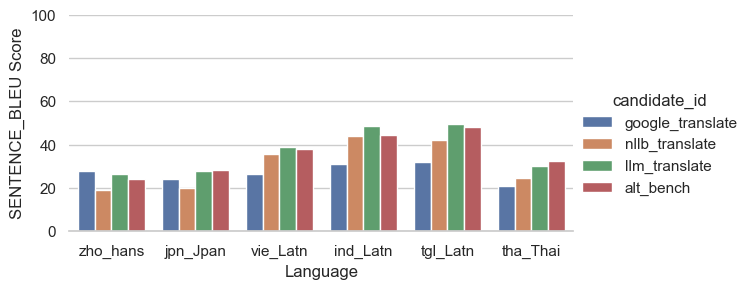

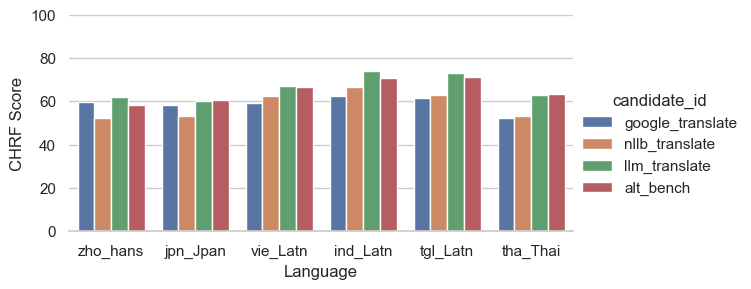

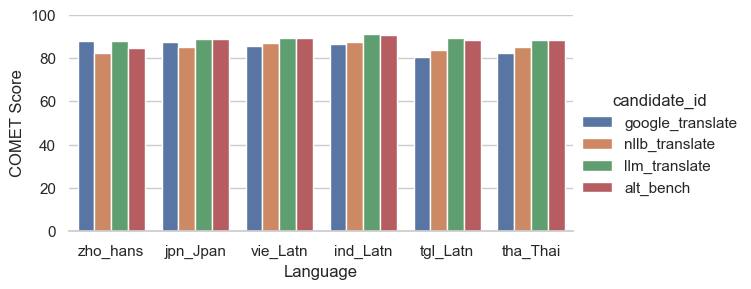

In [27]:
plot_ratings_graph(ratings_df, "sentence_bleu")
plot_ratings_graph(ratings_df, "chrf")
plot_ratings_graph(ratings_df, "comet")